In [76]:
import pandas as pd
import numpy as np
df = pd.read_csv("./MLC_SP23/clean_data/merged_data_v3.csv", low_memory=False, index_col=[0])

In [77]:
df.head()

,bbl,total_units_19,year_built,ejectment_count,possession_count,eviction_count,aleration_count,altered_lessthan5yrs,altered_morethan5yrs,classanet_avg,...,boro_3,boro_4,boro_5,rs_share_diff_new,hpd_call_2017_19,hh_inc_avg_19_log1,pop_race_asian_pct_19_log1,pop_race_black_pct_19_log1,pop16_unemp_pct_19_log1,pop_mobile1_diff_state_pct_19_log1
0,1000780047,483,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,4.0,12.276639,0.150551,0.018246,0.035008,0.074674
1,1001350019,4,1915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0.0,12.897523,0.096864,0.055298,0.002253,0.014341
2,1001620013,20,1915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.0,2.0,10.973689,0.461379,0.096629,0.037102,0.008935
3,1001630024,16,1915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,1.0,10.973689,0.461379,0.096629,0.037102,0.008935
4,1001630033,11,1915,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0.0,0.0,10.973689,0.461379,0.096629,0.037102,0.008935


In [78]:
df.columns

Index(['bbl', 'total_units_19', 'year_built', 'ejectment_count',
       'possession_count', 'eviction_count', 'aleration_count',
       'altered_lessthan5yrs', 'altered_morethan5yrs', 'classanet_avg',
       'enlargement_count', 'dob_calls_2017', 'dob_calls_2018',
       'dob_calls_2019', 'b_violations_2017', 'b_violations_2018',
       'b_violations_2019', 'c_violations_2017', 'c_violations_2018',
       'c_violations_2019', 'cases_2017', 'cases_2018', 'cases_2019',
       'Heat and Hot Water_2017', 'Heat and Hot Water_2018',
       'Heat and Hot Water_2019', 'Tenant Action_2017', 'Tenant Action_2018',
       'Tenant Action_2019', 'CONH_2017', 'CONH_2018', 'CONH_2019',
       'Tenant Action/Harrassment_2017', 'Tenant Action/Harrassment_2018',
       'Tenant Action/Harrassment_2019', 'hh_inc_own_med_19',
       'own_cost_mort_med_19', 'own_burden_mort_med_19',
       'rent_contract_med_19', 'rent_burden_med_19', 'pop_65p_pct_19',
       'pop_rent_pct_19', 'pop_race_white_pct_19', 'pop_

# Train-test split

In [79]:
X = df.drop(['rs_share_diff_new', 'bbl'], axis = 1)
y = df['rs_share_diff_new']

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [81]:
# Baseline accuracy
1 - y_train.mean()

0.6598096933187294

# Random Forest

In [111]:
# Fit model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import time

scoring = {'Accuracy':'accuracy',
           'F1 Score':'f1',
           'Precision':'precision',
           'Recall':'recall',
           'AUC':'roc_auc'
}

param_grid = {'max_depth':[8, 10, 12],
              'n_estimators': [250, 300, 350]
}

start = time.time()

rf = RandomForestClassifier(random_state = 1)
gr = GridSearchCV(rf, param_grid = param_grid, scoring = scoring, refit = "AUC", cv = 4)
fit = gr.fit(X_train, y_train)

end = time.time()

print("Running grid search took", end - start, "seconds") # time in seconds to run grid search
print()
print(fit.best_params_)
print(fit.best_score_)

Running grid search took 281.55832290649414 seconds

{'max_depth': 12, 'n_estimators': 350}
0.8079331437258767


In [112]:
# get all cv metrics for best model

best_params_index = fit.cv_results_['rank_test_AUC'][0] - 1
print("Best model AUC:", fit.cv_results_['mean_test_AUC'][best_params_index])
print("Best model accuracy:", fit.cv_results_['mean_test_Accuracy'][best_params_index])
print("Best model F1 score:", fit.cv_results_['mean_test_F1 Score'][best_params_index])
print("Best model precision:", fit.cv_results_['mean_test_Precision'][best_params_index])
print("Best model recall:", fit.cv_results_['mean_test_Recall'][best_params_index])

Best model AUC: 0.8077899348786055
Best model accuracy: 0.8246851040525739
Best model F1 score: 0.6778496516252243
Best model precision: 0.9040629428423129
Best model recall: 0.5422080793942399


In [113]:
# score model on test set
from sklearn import metrics

y_hat_test = fit.predict(X_test)
auc = metrics.roc_auc_score(y_test, y_hat_test)
acc = metrics.accuracy_score(y_test, y_hat_test)
f1 = metrics.f1_score(y_test, y_hat_test)
prec = metrics.precision_score(y_test, y_hat_test)
rec = metrics.recall_score(y_test, y_hat_test)

print("Out of sample AUC is:", auc)
print("Out of sample accuracy is:", acc)
print("Out of sample F1 score is:", f1)
print("Out of sample precision is:", prec)
print("Out of sample recall is:", rec)

Out of sample AUC is: 0.7570480836559823
Out of sample accuracy is: 0.8280110894342335
Out of sample F1 score is: 0.6786878956455017
Out of sample precision is: 0.9099794238683128
Out of sample recall is: 0.5411440807586417


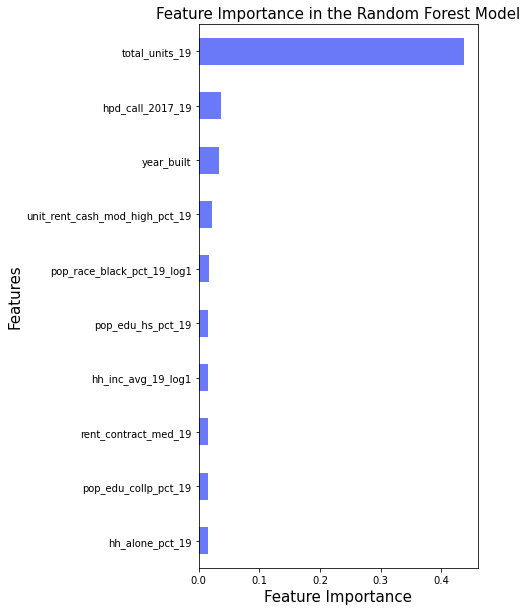

In [114]:
# get feature importance
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm

plt.figure(figsize=(5,10))
importances = pd.Series(fit.best_estimator_.feature_importances_, X_train.columns)
importances.sort_values().tail(10).plot.barh(color = '#6a79f7')
plt.title('Feature Importance in the Random Forest Model',fontsize=15)
plt.xlabel('Feature Importance',fontsize = 15)
plt.ylabel('Features',fontsize = 15)
plt.show()

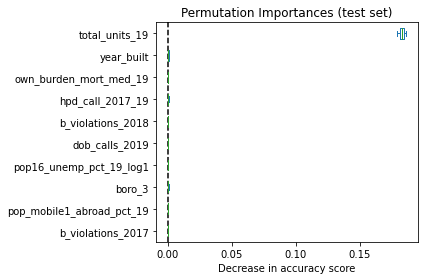

In [103]:
# permutation importance
from sklearn.inspection import permutation_importance

rf = fit.best_estimator_

result = permutation_importance(
    rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx][-10:].T,
    columns=X.columns[sorted_importances_idx][-10:],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

# Partial dependence

/Users/natehutchinson/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/Users/natehutchinson/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/Users/natehutchinson/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, c

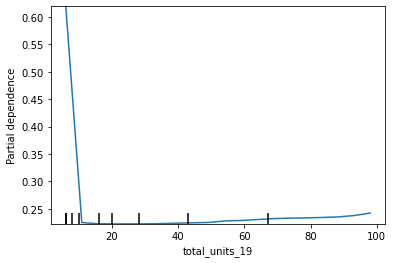

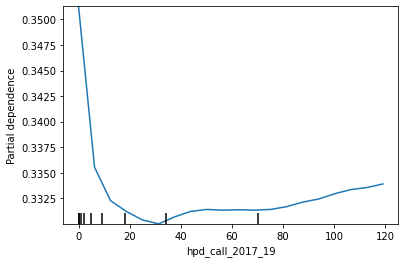

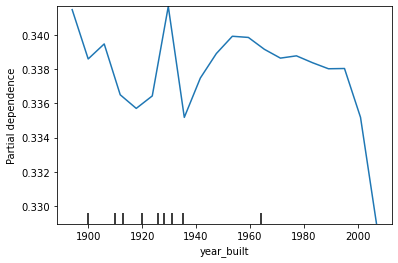

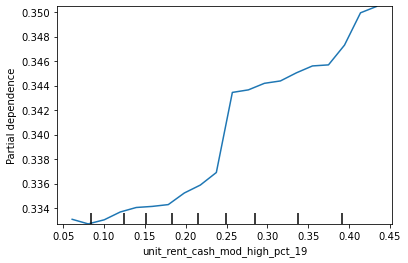

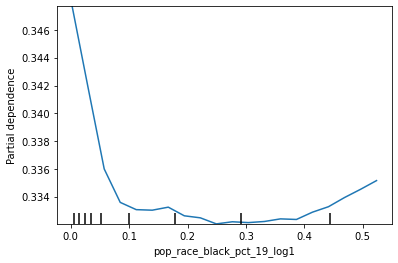

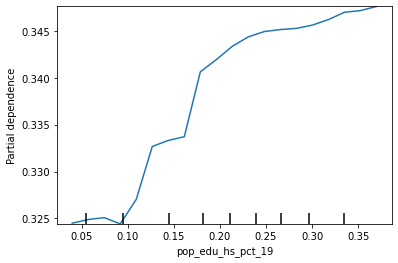

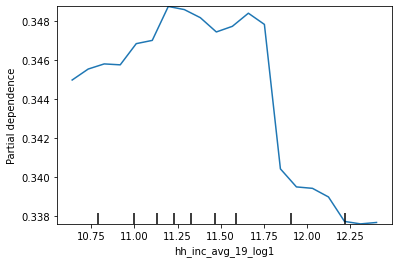

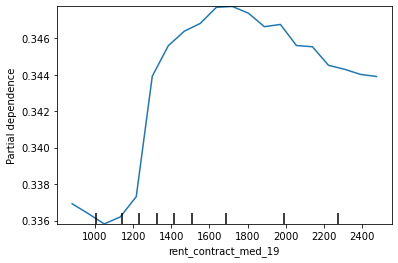

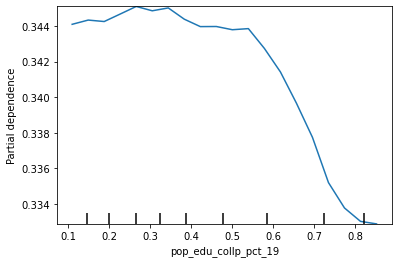

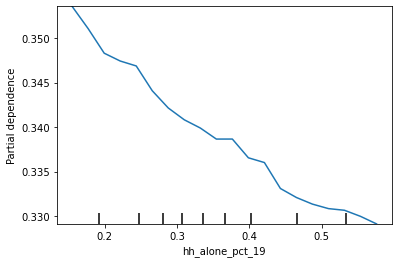

In [143]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

features = list(importances.sort_values(ascending = False)[:10].index)

for feature in features:
    plot_partial_dependence(fit, X_train, [feature], n_jobs=3, grid_resolution=20)
    fig = plt.gcf()
# fig.subplots_adjust(wspace=0.4, hspace=0.3)

In [152]:
df2 = df.copy()

df2['units_6_orless'] = np.where(df2['total_units_19'] < 7, 1, 0)
print("Sum of target variable by bldg size")
print(df2.groupby('units_6_orless')['rs_share_diff_new'].sum())
print()
print("Count of records by bldg size")
print(df2.groupby('units_6_orless').size())
print()
print("Avg of target variable by bldg size")
print(df2.groupby('units_6_orless')['rs_share_diff_new'].mean())


Sum of target variable by bldg size
units_6_orless
0    5899.0
1    7309.0
Name: rs_share_diff_new, dtype: float64

Count of records by bldg size
units_6_orless
0    30569
1     8386
dtype: int64

Avg of target variable by bldg size
units_6_orless
0    0.192973
1    0.871572
Name: rs_share_diff_new, dtype: float64


# Parameter tuning history

In [ ]:
# Initial run: max_depth = 6, n_estimators = 200
# 90 seconds

#Out of sample AUC is: 0.7441453436171275
#Out of sample accuracy is: 0.8207208132251771
#Out of sample F1 score is: 0.6568396226415095
#Out of sample precision is: 0.9186366135239142
#Out of sample recall is: 0.5111654940348731

In [45]:
# Slight improvement: max_depth = 8, n_estimators = 200
# 121 seconds

#Out of sample AUC is: 0.7495775499599772
#Out of sample accuracy is: 0.824519971249615
#Out of sample F1 score is: 0.6661457315882008
#Out of sample precision is: 0.9216216216216216
#Out of sample recall is: 0.5215662282043438

In [ ]:
# Another slight improvement: max_depth = 10, n_estimators = 300
# 230 seconds

#Out of sample AUC is: 0.7543915182811887
#Out of sample accuracy is: 0.8274976897012013
#Out of sample F1 score is: 0.67429236138038
#Out of sample precision is: 0.9205929062996294
#Out of sample recall is: 0.5319669623738146

In [ ]:
# drop total units

#Out of sample AUC is: 0.6607530670859816
#Out of sample accuracy is: 0.7484089509340998
#Out of sample F1 score is: 0.5130141068944963
#Out of sample precision is: 0.7252808988764045
#Out of sample recall is: 0.3968644328312327